# Introduction

In [2]:
# Preamble
## Imports
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

The global digital advertising market is worth approximately $602 billion today. Due to the increasing rate of of online participation since the COVID-19 pandemic, this number has been rapidly increasing and is expected to reach $871 billion by the end of 2027 ([eMarketer, 2024](#eMarketer)). Many of the of the major Ad platforms such as Google, Facebook and Amazon operate on a cost-per-user-engagement pricing model, which usually means that advertisers get charged for every time a user clicks on an advertisment. This means that these platforms are incentivized to make sure that the content shown to each user is as relevent as possible in order to maximize the number of clicks in the long term. Attaining accurate Click-Through Rate (CTR) prediction is a necessary first step for Ad persionalization, which is why study of CTR prediction methods have been an extremely active part of Machine Learning research over the past through years.

Initially, shallow prediction methods such as XGBoost (Cite), Factorization Machines (Cite) and Field-Aware Factorization Machines (Cite) have been used for CTR prediction. However, these methods have often been shown to be unable to capture the higher order feature interactions in the sparse multy value categorical Ad Marketplace datasets (Cite). Since then, Deep Learning methods have been shown to show superior predictive ability on these datasets. The focus of my reasearch project is therefore to explore the merits of different Deep Learning architechtures for click-through rate prediction

In the following report, I explore the relevant datasets and simulations that I will be using throughout my research project. In the first section, I perform an exploratory data analysis on three widely adopted benchmark CTR prediction datasets; the KDD12 ([Aden, 2012](#kdd12)), Avazu ([Wang and Cukierski, 2014](#avazu)) and Criteo ([Tien et al, 2014](#criteo)) datasets. In the second section, I then explore possible ways of simulating the ad marketplace environment in order to test the reinforcement learning framework.

# Datasets

## KDD12

The __KDD12__ dataset was first released for the KDD Cup 2012 competition (Cite), with the original task being to predict the number of clicks for a given number of impressions. Each line represents a training instance derived from the session logs for the advertizing marketplace. In the context of this dataset, a "session" refers to an interaction between a user and the search engine, containing the following components; the user, a list of adverts returned by the search engine and shown (impressed) to the user and zero or more adverts clicked on by the user. Each line in the training set includes:

- __Clicks__: The number of times the user has clicked on the given Ad among the relevant Impressions.
- __Impressions__: The number of search sessions in which the Ad was impressed by the user after issuing the specific Query.
- __Display URL__: The URL link displayed along with the advert.
- __Ad ID__: An identifier for each advertisment.
- __Advertiser ID__: An identifier that specified the company that issued the advertisment.
- __Depth__: The number of Ads that the user viewed (impressed) in a session. 
- __Position__: The order in which the specific advert was displayed to the user within the session.
- __Query ID__
- __Keyword ID__
- __Title ID__
- __Description ID__
- __User ID__

Below, I show a sample of records in the training set:

In [8]:
# Show firt 5 rows of the training dataset
data = pd.read_csv('.\data\kdd12\kdd12_training.csv')
data.head() 

,Click,Impression,DisplayURL,AdID,AdvertiserID,Depth,Position,QueryID,KeywordID,TitleID,DescriptionID,UserID
0,0,1,4298118681424644510,7686695,385,3,3,1601,5521,7709,576,490234
1,0,1,4860571499428580850,21560664,37484,2,2,2255103,317,48989,44771,490234
2,0,1,9704320783495875564,21748480,36759,3,3,4532751,60721,685038,29681,490234
3,0,1,13677630321509009335,3517124,23778,3,1,1601,2155,1207,1422,490234
4,0,1,3284760244799604489,20758093,34535,1,1,4532751,77819,266618,222223,490234


The last four variables in the list above act as joining keys to secondary datasets containing the tokenized __search query phrases, the purchased keywords, title and descriptions for each ad, and user demographic data (age range and gender)__. Below I show sampled values for the __Query__ and __User__ datasets respectively:

In [8]:
# Display sample of Query and User datasets
print("Query Dataset:")
display(pd.read_csv('.\data\kdd12\kdd12_query.csv').head())
print("User Dataset:")
display(pd.read_csv('.\data\kdd12\kdd12_user.csv').head())

Query Dataset:


,QueryID,QueryTokens
0,0,12731
1,1,1545|75|31
2,2,383
3,3,518|1996
4,4,4189|75|31


User Dataset:


,UserID,Gender,Age
0,1,1,5
1,2,2,3
2,3,1,5
3,4,1,3
4,5,2,1


Note that in the User table above, Gender is encoded as '1'-Male, '2'-Female and '0'-Unknown, whereas Age is encoded as '1'-'from 0 to 12 years', '2'-(12,18], '3'-(18,24], '4'-(24,30], '5'-(30,40] and '6'-'greater than 40'.

Since the original purpose of the competition was to predict the number of clicks in each instance, the target variable (clicks) and the impressions variable takes on non-negative integer values. In the figure below we see that in over 95% of the instances, the user did not click on the Ad:

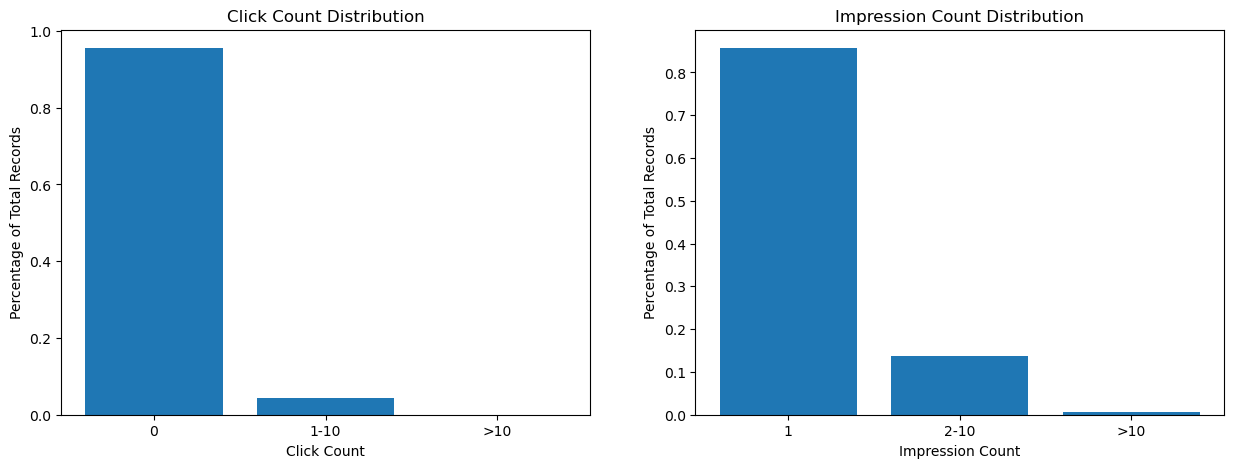

In [4]:
# Show plots of the percentage of records per click and impression count values
click_counts = pd.read_csv('./data/kdd12/kdd12_click_counts.csv').sort_values(by='click')
impression_counts = pd.read_csv('./data/kdd12/kdd12_impression_counts.csv').sort_values(by='impression')

## Bin the click and impression counts
click_counts['click_count_bin'] = np.where(
    click_counts['click'] ==0, '0',
    np.where(click_counts['click'] < 11, '1-10','>10'))
click_counts = click_counts.groupby('click_count_bin').agg({'record_count':'sum'}).reset_index()

impression_counts['impression_count_bin'] = np.where(
    impression_counts['impression'] ==1, '1',
    np.where(impression_counts['impression'] < 11, '2-10','>10'))
impression_counts = impression_counts.groupby('impression_count_bin').agg({'record_count':'sum'}).reset_index()

## Calculate the percentage of records per value count bin
click_counts['percentage_of_total'] = click_counts['record_count']/click_counts['record_count'].sum()
impression_counts['percentage_of_total'] = impression_counts['record_count']/impression_counts['record_count'].sum()

## Plot the results 
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(click_counts['click_count_bin'], click_counts['percentage_of_total'])
ax[0].set_title('Click Count Distribution')
ax[0].set_xlabel('Click Count')
ax[0].set_ylabel('Percentage of Total Records')
ax[1].bar(impression_counts['impression_count_bin'], impression_counts['percentage_of_total'])
ax[1].set_title('Impression Count Distribution')
ax[1].set_xlabel('Impression Count')
ax[1].set_ylabel('Percentage of Total Records')
plt.show()

To adjust this dataset to the task of __Click Through Rate predeiction__ as opposed to __Click volume prediction__, one can proceed by calculating the Click Through rate in each instance by dividing the number of clicks by the number of impressions, as done in (Cite Song, others).

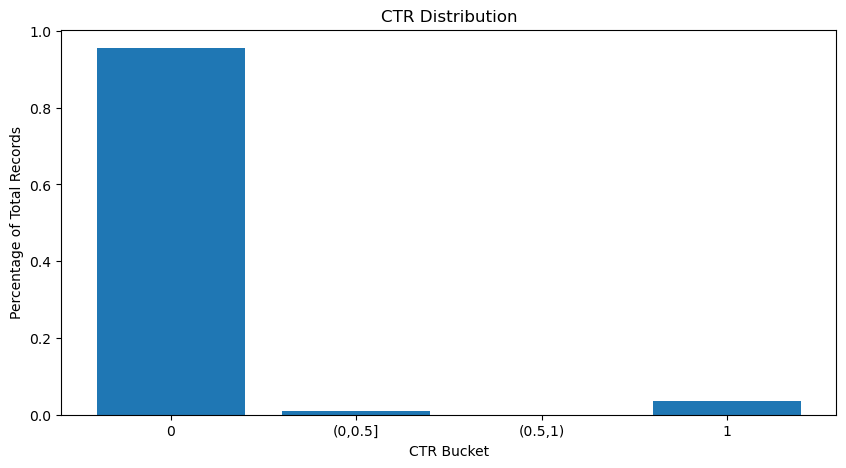

In [7]:
# Read in the CTR distribution dataset
ctr_dist = pd.read_csv('./data/kdd12/kdd12_ctr_dist.csv')

# Sort the dataset ctr buckets
sort_dict = {
    '0':0,
    '(0,0.5]':1,
    '(0.5,1)':2,
    '1':3
}
ctr_dist = ctr_dist.sort_values(by='ctr_bin', key=lambda x: x.map(sort_dict))

# Calculate the percentage of records per CTR bucket
ctr_dist['percentage_of_total'] = ctr_dist['record_count']/ctr_dist['record_count'].sum()

# Plot the CTR distribution
plt.figure(figsize=(10,5))
plt.bar(ctr_dist['ctr_bin'], ctr_dist['percentage_of_total'])
plt.title('CTR Distribution')
plt.xlabel('CTR Bucket')
plt.ylabel('Percentage of Total Records')
plt.show()


The task for CTR prediction with this dataset is therefor characterized by defining the influence that the different features and interactions have on the CTR. Out of the features listed above, only __Depth__ and __Position__ are non-categorical, and each of these take on values from 1 to 3:

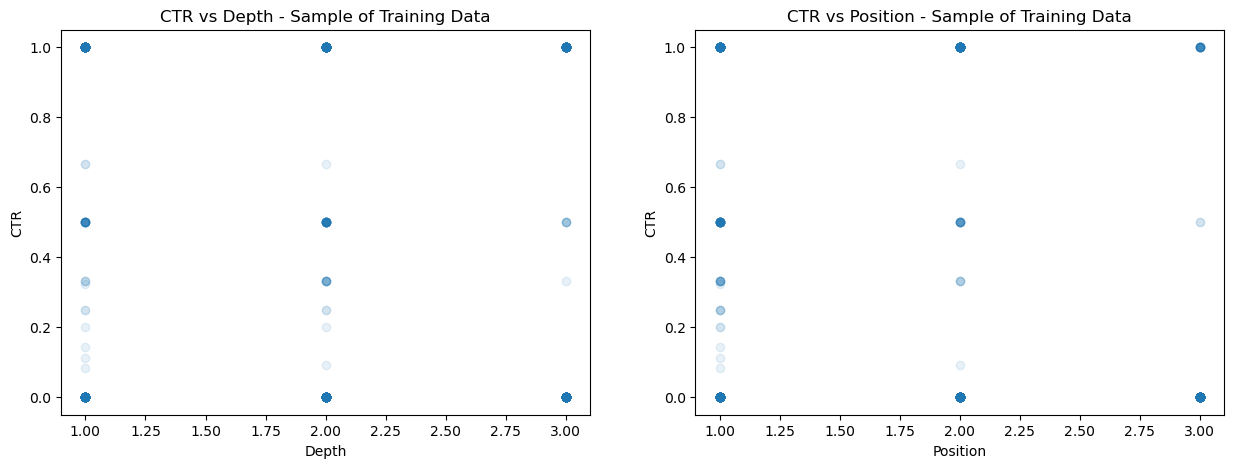

In [11]:
# Add ctr metric to the training dataset sample

data['ctr'] = data['Click']/data['Impression']

# Plot CTR vs Depth and Position
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].scatter(data['Depth'], data['ctr'],alpha=0.1)
ax[0].set_title('CTR vs Depth - Sample of Training Data')
ax[0].set_xlabel('Depth')
ax[0].set_ylabel('CTR')
ax[1].scatter(data['Position'], data['ctr'],alpha=0.1)
ax[1].set_title('CTR vs Position - Sample of Training Data')
ax[1].set_xlabel('Position')
ax[1].set_ylabel('CTR')
plt.show()

## Avazu

## Criteo

# Simulatinons

# Summary of findings

# Suggested Future Research

<a class="anchor" id="references"></a>

# References

<a class="anchor" id="eMarketer"></a>

- eMarketer. (2023). Digital advertising spending worldwide from 2021 to 2027 (in billion U.S. dollars) . Statista. Statista Inc.. Accessed: June 09, 2024. https://www-statista-com.iclibezp1.cc.ic.ac.uk/statistics/237974/online-advertising-spending-worldwide/

<a class="anchor" id="kdd12"></a>

- Aden, Yi Wang. (2012). KDD Cup 2012, Track 2. Kaggle. https://kaggle.com/competitions/kddcup2012-track2

<a class="anchor" id="avazu"></a>

- Steve Wang, Will Cukierski. (2014). Click-Through Rate Prediction. Kaggle. https://kaggle.com/competitions/avazu-ctr-prediction

<a class="anchor" id="criteo"></a>

- Jean-Baptiste Tien, joycenv, Olivier Chapelle. (2014). Display Advertising Challenge. Kaggle. https://kaggle.com/competitions/criteo-display-ad-challenge